In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facebook-ego/698.featnames
/kaggle/input/facebook-ego/3980.featnames
/kaggle/input/facebook-ego/686.egofeat
/kaggle/input/facebook-ego/3437.circles
/kaggle/input/facebook-ego/1912.featnames
/kaggle/input/facebook-ego/1684.featnames
/kaggle/input/facebook-ego/1684.egofeat
/kaggle/input/facebook-ego/3437.feat
/kaggle/input/facebook-ego/3437.featnames
/kaggle/input/facebook-ego/686.circles
/kaggle/input/facebook-ego/107.featnames
/kaggle/input/facebook-ego/348.egofeat
/kaggle/input/facebook-ego/0.feat
/kaggle/input/facebook-ego/698.feat
/kaggle/input/facebook-ego/686.feat
/kaggle/input/facebook-ego/107.feat
/kaggle/input/facebook-ego/348.feat
/kaggle/input/facebook-ego/698.circles
/kaggle/input/facebook-ego/0.circles
/kaggle/input/facebook-ego/414.edges
/kaggle/input/facebook-ego/414.feat
/kaggle/input/facebook-ego/1684.feat
/kaggle/input/facebook-ego/698.egofeat
/kaggle/input/facebook-ego/414.circles
/kaggle/input/facebook-ego/1912.edges
/kaggle/input/facebook-ego/1684.edge

In [3]:
# ===== CONFIG =====
EDGES_PATH   = "/kaggle/input/facebook-combined/facebook_combined.txt"
EGO_DIR      = "/kaggle/input/facebook-ego"   # thư mục chứa *.feat, *.featnames, *.egofeat
LABELS_PATH  = None                           # CSV có cột u,v,label (nếu có thì điền path)

NODE_TARGET   = 414
TOPK          = 10
POS_FRAC_HIDE = 0.10      # tự tạo nhãn: ẩn 10% cạnh làm positive
NEG_RATIO     = 1.0       # số negative ≈ positive
SEED          = 42

# Nhóm tên 'shared' được SUY từ chính tên trong *.featnames bằng tiền tố tách theo ';'
GROUPING_DEPTH = 1        # 1 -> 'education', 2 -> 'education;year', ...
MAX_NAMES_PER_GROUP = 12  # số tên hiển thị tối đa trong mỗi nhóm

# ===== IMPORTS =====
import os, glob
import numpy as np, pandas as pd, networkx as nx
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

np.random.seed(SEED)


In [4]:
def load_graph(path: str) -> nx.Graph:
    G = nx.Graph()
    with open(path, "r") as f:
        for line in f:
            u, v = map(int, line.split())
            G.add_edge(u, v)
    return G

G = load_graph(EDGES_PATH)
print("Nodes:", G.number_of_nodes(), "| Edges:", G.number_of_edges(), "| Directed?", G.is_directed())


Nodes: 4039 | Edges: 88234 | Directed? False


In [5]:
def load_all_ego_spaces(ego_dir: str):
    """
    ego_featnames:  ego_id -> {local_idx: name}
    ego_node2local: ego_id -> {node_id: set(local_idx)}
    node2global_feats: node_id -> set of (ego_id, local_idx)
    """
    ego_featnames, ego_node2local = {}, {}
    node2global_feats = defaultdict(set)

    featname_files = sorted(glob.glob(os.path.join(ego_dir, "*.featnames")))
    for fn in featname_files:
        ego_id = int(os.path.basename(fn).split(".")[0])

        # 1) featnames
        featnames = {}
        with open(fn, "r", encoding="utf-8") as f:
            for line in f:
                idx_str, name = line.strip().split(" ", 1)
                featnames[int(idx_str)] = name
        ego_featnames[ego_id] = featnames

        # 2) feat
        feat_file = fn.replace(".featnames", ".feat")
        node2local = defaultdict(set)
        if os.path.exists(feat_file):
            with open(feat_file, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    node = int(parts[0])
                    bits = list(map(int, parts[1:]))
                    for i, b in enumerate(bits):
                        if b == 1:
                            node2local[node].add(i)
                            node2global_feats[node].add((ego_id, i))

        # 3) egofeat (thuộc tính của chính ego)
        egofeat_file = fn.replace(".featnames", ".egofeat")
        if os.path.exists(egofeat_file):
            bits = list(map(int, open(egofeat_file, "r").read().strip().split()))
            for i, b in enumerate(bits):
                if b == 1:
                    node2local[ego_id].add(i)
                    node2global_feats[ego_id].add((ego_id, i))

        ego_node2local[ego_id] = dict(node2local)

    return ego_featnames, ego_node2local, dict(node2global_feats)

ego_featnames, ego_node2local, node2global_feats = load_all_ego_spaces(EGO_DIR)
print("Num ego graphs:", len(ego_featnames))
print("Nodes with any ego features:", len(node2global_feats))


Num ego graphs: 10
Nodes with any ego features: 4031


In [6]:
def jaccard_sets(a, b):
    if not a and not b: return 0.0
    inter = len(a & b); union = len(a | b)
    return inter / union if union else 0.0

def cosine_sets(a, b):
    if not a or not b: return 0.0
    inter = len(a & b)
    denom = (len(a) * len(b)) ** 0.5
    return inter / denom if denom else 0.0

def overlap_names_from_pairs(overlap_pairs):
    """overlap_pairs: set((ego_id, local_idx)) -> list tên thuộc tính."""
    names = []
    for (ego_id, i) in list(overlap_pairs)[:1000]:
        nm = ego_featnames.get(ego_id, {}).get(i)
        if nm is not None:
            names.append(nm)
    return names

def extract_group(name: str, depth: int = 1) -> str:
    """
    Suy nhóm từ chính tên thuộc tính trong *.featnames, tách theo ';'
    ví dụ 'education;year;id;...' -> depth=1: 'education', depth=2: 'education;year'
    """
    parts = [p.strip().lower() for p in name.split(";") if p.strip()]
    if not parts: return "other"
    take = min(depth, len(parts))
    return ";".join(parts[:take])


In [7]:
def features_for_pairs_plus(G: nx.Graph, pairs):
    pairs = [(int(u), int(v)) for (u,v) in pairs if u in G and v in G and u != v]

    # --- Cấu trúc ---
    def cn_count(u, v):
        try:    return sum(1 for _ in nx.common_neighbors(G, u, v))
        except: return 0
    cn = {(u,v): cn_count(u,v) for (u,v) in pairs}
    jacc = {(u,v): s for (u,v,s) in nx.jaccard_coefficient(G, pairs)}
    aa   = {(u,v): s for (u,v,s) in nx.adamic_adar_index(G, pairs)}
    pa   = {(u,v): s for (u,v,s) in nx.preferential_attachment(G, pairs)}
    spl  = {}
    for (u,v) in pairs:
        try: spl[(u,v)] = nx.shortest_path_length(G, u, v)
        except: spl[(u,v)] = 99

    # --- Ego ---
    rows = []
    for (u,v) in pairs:
        Au = set(node2global_feats.get(u, set()))
        Av = set(node2global_feats.get(v, set()))
        inter_pairs = Au & Av

        rows.append({
            "u":u, "v":v,
            "cn": cn.get((u,v),0),
            "jaccard": jacc.get((u,v),0.0),
            "adamic_adar": aa.get((u,v),0.0),
            "pref_attach": pa.get((u,v),0),
            "sp_len": spl.get((u,v),99),
            "feat_overlap": len(inter_pairs),
            "feat_jaccard": jaccard_sets(Au, Av),
            "feat_cosine":  cosine_sets(Au, Av),
            "_overlap_pairs": list(inter_pairs)
        })
    return pd.DataFrame(rows)


In [8]:
def build_supervised_dataset_with_content(G: nx.Graph, labels_path: str = None,
                                          pos_frac_hide=0.1, neg_ratio=1.0, seed=42):
    rng = np.random.default_rng(seed)

    if labels_path and os.path.exists(labels_path):
        lab = pd.read_csv(labels_path)
        assert set(["u","v","label"]).issubset(lab.columns), "labels.csv cần cột u,v,label"
        pairs = list(zip(lab["u"].astype(int), lab["v"].astype(int)))
        F = features_for_pairs_plus(G, pairs)
        F["label"] = lab["label"].astype(int).values
        X = F.drop(columns=["u","v","label","_overlap_pairs"])
        y = F["label"].astype(int)
        return X, y, G

    # tự tạo nhãn
    edges = list(G.edges()); rng.shuffle(edges)
    m_hide = max(1, int(pos_frac_hide * len(edges)))
    pos_edges = edges[:m_hide]

    G_feat = G.copy()
    G_feat.remove_edges_from(pos_edges)  # tránh leakage

    target_neg = int(neg_ratio * m_hide)
    neg_edges, nodes = set(), list(G_feat.nodes())
    while len(neg_edges) < target_neg:
        u, v = rng.choice(nodes, 2, replace=False)
        if not G_feat.has_edge(u, v):
            neg_edges.add((int(u), int(v)))
    neg_edges = list(neg_edges)

    F_pos = features_for_pairs_plus(G_feat, pos_edges); F_pos["label"] = 1
    F_neg = features_for_pairs_plus(G_feat, neg_edges); F_neg["label"] = 0
    F_all = pd.concat([F_pos, F_neg], ignore_index=True)

    X = F_all.drop(columns=["u","v","label","_overlap_pairs"])
    y = F_all["label"].astype(int)
    return X, y, G_feat

X, y, G_feat_graph = build_supervised_dataset_with_content(
    G, LABELS_PATH, pos_frac_hide=POS_FRAC_HIDE, neg_ratio=NEG_RATIO, seed=SEED
)
print("Dataset:", X.shape, "| positives:", int(y.sum()), "| negatives:", int((1-y).sum()))

# Train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
rf = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=SEED)
rf.fit(X_train, y_train)

proba = rf.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)
print("ROC-AUC:", roc_auc_score(y_test, proba).round(4))
print(classification_report(y_test, pred, digits=4))

imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
display(imp.head(15))


Dataset: (17646, 8) | positives: 8823 | negatives: 8823
ROC-AUC: 0.9926
              precision    recall  f1-score   support

           0     0.9784    0.9745    0.9764      1765
           1     0.9746    0.9785    0.9765      1765

    accuracy                         0.9765      3530
   macro avg     0.9765    0.9765    0.9765      3530
weighted avg     0.9765    0.9765    0.9765      3530



adamic_adar     0.319050
cn              0.206556
jaccard         0.173252
sp_len          0.110583
feat_overlap    0.061857
feat_cosine     0.060361
feat_jaccard    0.046461
pref_attach     0.021880
dtype: float64

In [9]:
def candidates_by_distance(G: nx.Graph, u0: int, exact_dist=None, min_dist=None, cutoff=6):
    nbrs = set(G.neighbors(u0))
    out = []
    dists = nx.single_source_shortest_path_length(G, u0, cutoff=cutoff)
    for v, d in dists.items():
        if v == u0 or v in nbrs: 
            continue
        if exact_dist is not None and d == exact_dist:
            out.append(v)
        elif min_dist is not None and d >= min_dist:
            out.append(v)
    return out

def recommend_for_candidates_plus(u0, candidates, model, G_feat, topk=10):
    pairs = [(u0, v) for v in candidates]
    F = features_for_pairs_plus(G_feat, pairs)   # trích trên G_feat (đã tránh rò rỉ)
    probs = model.predict_proba(F.drop(columns=["u","v","_overlap_pairs"]))[:,1]
    F["p"] = probs
    return F.sort_values("p", ascending=False).head(topk).reset_index(drop=True)

u0 = NODE_TARGET
cand_d2  = candidates_by_distance(G, u0, exact_dist=2)
cand_d3p = candidates_by_distance(G, u0, min_dist=3)

top_d2  = recommend_for_candidates_plus(u0, cand_d2,  rf, G_feat_graph, topk=TOPK)
top_d3p = recommend_for_candidates_plus(u0, cand_d3p, rf, G_feat_graph, topk=TOPK)

print(f"#candidates dist=2 : {len(cand_d2)}")
print(f"#candidates dist≥3: {len(cand_d3p)}")


#candidates dist=2 : 1217
#candidates dist≥3: 2662


In [10]:
def summary_block(df, tag):
    if df.empty:
        print(f"\n[{tag}] Không có kết quả.")
        return
    cols = ["p","cn","jaccard","adamic_adar","pref_attach","feat_overlap","feat_cosine","sp_len"]
    s = df[cols].agg(["count","mean","median","min","max"]).T.round(4)
    print(f"\n=== THỐNG KÊ NHANH — {tag} ===")
    display(s)

    group_counter = Counter()
    name_counter  = Counter()
    for _, r in df.iterrows():
        pairs = set(map(tuple, r["_overlap_pairs"]))
        names = overlap_names_from_pairs(pairs)
        for nm in names:
            group_counter[extract_group(nm, GROUPING_DEPTH)] += 1
            name_counter[nm] += 1

    if group_counter:
        print("Top nhóm (từ featnames):")
        for g, c in group_counter.most_common(10):
            print(f"  - {g} : {c} lần")

    if name_counter:
        print("Top thuộc tính trùng (từ featnames):")
        for n, c in name_counter.most_common(10):
            print(f"  - {n} : {c} lần")

def explain_row(r):
    overlap_pairs = set(map(tuple, r["_overlap_pairs"]))
    names = overlap_names_from_pairs(overlap_pairs)
    if not names:
        return "shared: —"

    grouped = defaultdict(list)
    for nm in names:
        grouped[extract_group(nm, GROUPING_DEPTH)].append(nm)

    order = sorted(grouped.keys(), key=lambda k: (-len(grouped[k]), k))
    parts = []
    for g in order:
        uniq = sorted(set(grouped[g]))[:MAX_NAMES_PER_GROUP]
        parts.append(f"{g}=[{'; '.join(uniq)}]")
    return "shared: " + "; ".join(parts)

def print_detailed(df, tag):
    print(f"\n=== Top-{len(df)} chi tiết — {tag} ===")
    for i, r in df.iterrows():
        print(f"{i+1:>2}. v={int(r.v):<5} p={r.p:.3f}  "
              f"CN={int(r.cn):<3} J={r.jaccard:.4f} AA={r.adamic_adar:.3f}  "
              f"Fo={int(r.feat_overlap):<2} Fc={r.feat_cosine:.3f} dist={int(r.sp_len)}")
        print("    " + explain_row(r))

summary_block(top_d2,  "dist=2 (bạn của bạn)")
print_detailed(top_d2, "dist=2")

summary_block(top_d3p, "dist≥3 (bạn của bạn của bạn…)")
print_detailed(top_d3p, "dist≥3")



=== THỐNG KÊ NHANH — dist=2 (bạn của bạn) ===


,count,mean,median,min,max
p,10.0,0.9972,0.9975,0.9925,1.0000
cn,10.0,19.0000,15.5000,11.0000,29.0000
jaccard,10.0,0.1134,0.1000,0.0625,0.1562
adamic_adar,10.0,4.4567,3.6703,2.4874,6.9117
pref_attach,10.0,5829.0000,5292.5000,3190.0000,10730.0000
feat_overlap,10.0,5.3000,6.0000,1.0000,8.0000
feat_cosine,10.0,0.2301,0.2346,0.0762,0.3522
sp_len,10.0,2.0000,2.0000,2.0000,2.0000


Top nhóm (từ featnames):
  - education : 35 lần
  - locale : 9 lần
  - gender : 5 lần
  - hometown : 4 lần
Top thuộc tính trùng (từ featnames):
  - locale;anonymized feature 127 : 9 lần
  - education;type;anonymized feature 54 : 8 lần
  - education;type;anonymized feature 53 : 7 lần
  - education;type;anonymized feature 55 : 7 lần
  - education;school;id;anonymized feature 52 : 6 lần
  - gender;anonymized feature 78 : 5 lần
  - hometown;id;anonymized feature 84 : 4 lần
  - education;school;id;anonymized feature 228 : 3 lần
  - education;concentration;id;anonymized feature 15 : 3 lần
  - education;year;id;anonymized feature 67 : 1 lần

=== Top-10 chi tiết — dist=2 ===
 1. v=417   p=1.000  CN=27  J=0.1561 AA=6.351  Fo=1  Fc=0.088 dist=2
    shared: locale=[locale;anonymized feature 127]
 2. v=507   p=1.000  CN=27  J=0.1552 AA=6.326  Fo=4  Fc=0.231 dist=2
    shared: education=[education;school;id;anonymized feature 52; education;type;anonymized feature 54]; gender=[gender;anonymized feat

,count,mean,median,min,max
p,10.0,0.0162,0.0162,0.005,0.0274
cn,10.0,0.0000,0.0000,0.000,0.0000
jaccard,10.0,0.0000,0.0000,0.000,0.0000
adamic_adar,10.0,0.0000,0.0000,0.000,0.0000
pref_attach,10.0,9222.0000,8917.5000,0.000,20155.0000
feat_overlap,10.0,0.0000,0.0000,0.000,0.0000
feat_cosine,10.0,0.0000,0.0000,0.000,0.0000
sp_len,10.0,51.1000,51.5000,3.000,99.0000



=== Top-10 chi tiết — dist≥3 ===
 1. v=256   p=0.027  CN=0   J=0.0000 AA=0.000  Fo=0  Fc=0.000 dist=99
    shared: —
 2. v=3729  p=0.027  CN=0   J=0.0000 AA=0.000  Fo=0  Fc=0.000 dist=99
    shared: —
 3. v=292   p=0.027  CN=0   J=0.0000 AA=0.000  Fo=0  Fc=0.000 dist=99
    shared: —
 4. v=287   p=0.027  CN=0   J=0.0000 AA=0.000  Fo=0  Fc=0.000 dist=99
    shared: —
 5. v=892   p=0.027  CN=0   J=0.0000 AA=0.000  Fo=0  Fc=0.000 dist=99
    shared: —
 6. v=2485  p=0.005  CN=0   J=0.0000 AA=0.000  Fo=0  Fc=0.000 dist=3
    shared: —
 7. v=2370  p=0.005  CN=0   J=0.0000 AA=0.000  Fo=0  Fc=0.000 dist=3
    shared: —
 8. v=1926  p=0.005  CN=0   J=0.0000 AA=0.000  Fo=0  Fc=0.000 dist=3
    shared: —
 9. v=2153  p=0.005  CN=0   J=0.0000 AA=0.000  Fo=0  Fc=0.000 dist=4
    shared: —
10. v=2086  p=0.005  CN=0   J=0.0000 AA=0.000  Fo=0  Fc=0.000 dist=3
    shared: —


[INFO] subgraph nodes: 2857, edges: 57005
[INFO] rec dist=2 tổng: 10 | cần vẽ (chưa tồn tại): 10


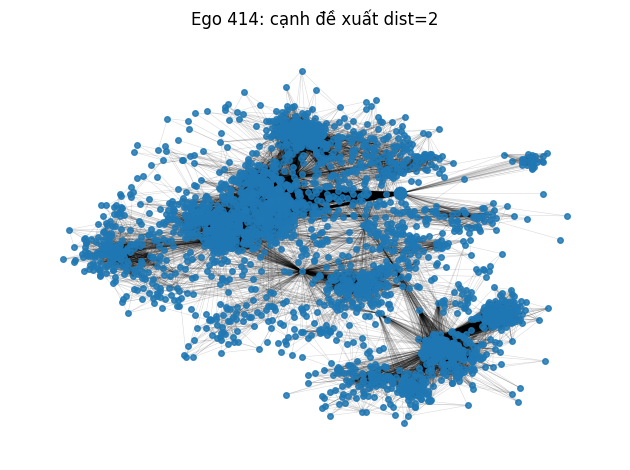

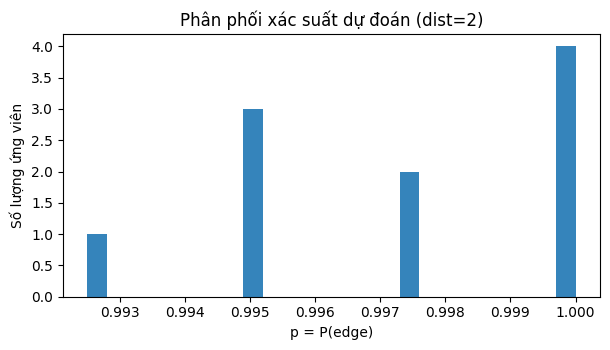

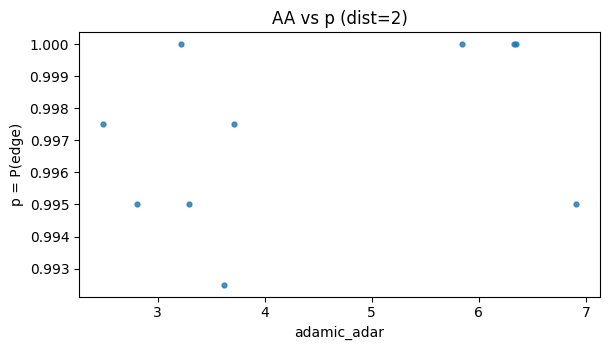

In [11]:
# ====== IMPORTS ======
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ====== THAM SỐ ======
radius = 3  # bán kính ego để lấy "lõi" xung quanh u0
# u0 = <NODE_TARGET>      # đảm bảo đã có
# top_d2 = ...            # DataFrame kết quả dist=2

# ====== CHUYỂN TOP_D2 -> DANH SÁCH CẠNH ĐỀ XUẤT dist=2 ======
def pairs_from_df(df, ego):
    return [(int(ego), int(v)) for v in df["v"].tolist()]

rec_edges_d2 = pairs_from_df(top_d2, u0) if "top_d2" in globals() else []

# ====== CHỌN ĐỒ THỊ GỐC ======
base_G = G_feat_graph if "G_feat_graph" in globals() else G
if u0 not in base_G:
    raise ValueError(f"u0={u0} không nằm trong đồ thị.")

# ====== MỞ RỘNG SUBGRAPH ĐỂ CHỨA ĐỦ NODE CẦN VẼ (Cách B gọn) ======
H_core = nx.ego_graph(base_G, u0, radius=radius)
nodes_needed = set(H_core.nodes())
for u, v in rec_edges_d2:
    if base_G.has_node(u) and base_G.has_node(v):
        nodes_needed.add(int(u)); nodes_needed.add(int(v))
H = base_G.subgraph(nodes_needed).copy()

# Chỉ vẽ cạnh đề xuất chưa tồn tại trong H để nổi bật
def drop_existing(H, edgelist):
    out = []
    for u, v in edgelist:
        a, b = int(u), int(v)
        if not H.has_edge(a, b):
            out.append((a, b))
    return out

rec_edges_d2_new = drop_existing(H, rec_edges_d2)

print(f"[INFO] subgraph nodes: {H.number_of_nodes()}, edges: {H.number_of_edges()}")
print(f"[INFO] rec dist=2 tổng: {len(rec_edges_d2)} | cần vẽ (chưa tồn tại): {len(rec_edges_d2_new)}")

# ====== VẼ 1 HÌNH: Dist = 2 ======
pos = nx.spring_layout(H, seed=42)

# nền nhạt
nx.draw_networkx_edges(H, pos, edgelist=list(H.edges()), width=0.4, alpha=0.15)
nx.draw_networkx_nodes(H, pos, node_size=16, alpha=0.85)

# ego nổi bật
if H.has_node(u0):
    nx.draw_networkx_nodes(H, pos, nodelist=[u0], node_size=80)

# cạnh đề xuất dist=2 tô đậm + các node liên quan
if rec_edges_d2_new:
    nx.draw_networkx_edges(H, pos, edgelist=rec_edges_d2_new, width=2.2, style='-')
    rec_nodes_d2 = {n for e in rec_edges_d2_new for n in e}
    nx.draw_networkx_nodes(H, pos, nodelist=list(rec_nodes_d2), node_size=30)

plt.title(f"Ego {u0}: cạnh đề xuất dist=2")
plt.axis("off")
plt.tight_layout()
plt.show()

# ====== (TUỲ CHỌN) 2 BIỂU ĐỒ NHANH CHO TOP_D2 ======
if "top_d2" in globals() and not top_d2.empty:
    # 1) Histogram của p
    plt.figure(figsize=(6.2, 3.6))
    plt.hist(top_d2["p"], bins=25, alpha=0.9)
    plt.title("Phân phối xác suất dự đoán (dist=2)")
    plt.xlabel("p = P(edge)"); plt.ylabel("Số lượng ứng viên")
    plt.tight_layout(); plt.show()

    # 2) Scatter quan hệ Adamic-Adar và p
    plt.figure(figsize=(6.2, 3.6))
    plt.scatter(top_d2["adamic_adar"], top_d2["p"], s=12, alpha=0.8)
    plt.title("AA vs p (dist=2)")
    plt.xlabel("adamic_adar"); plt.ylabel("p = P(edge)")
    plt.tight_layout(); plt.show()


[INFO] H_small nodes: 11, edges: 10


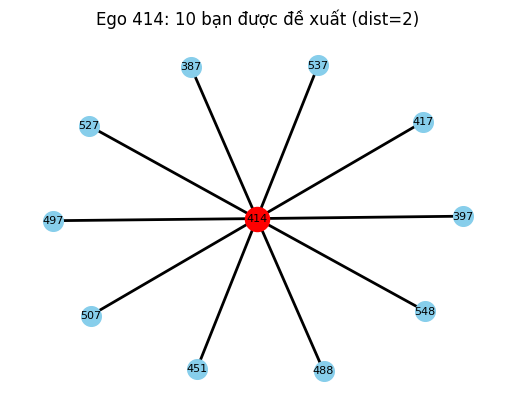

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Lấy đúng 10 bạn đề xuất từ top_d2
top10_d2 = top_d2.head(10)
rec_edges_top10 = [(int(u0), int(v)) for v in top10_d2["v"].tolist()]

# Tạo đồ thị con chỉ chứa ego và 10 node đề xuất
H_small = nx.Graph()
H_small.add_node(u0)
H_small.add_edges_from(rec_edges_top10)

print(f"[INFO] H_small nodes: {H_small.number_of_nodes()}, edges: {H_small.number_of_edges()}")

# Vẽ
pos = nx.spring_layout(H_small, seed=42)

nx.draw_networkx_nodes(H_small, pos, node_size=300, nodelist=[u0], node_color="red", label=f"ego {u0}")
nx.draw_networkx_nodes(H_small, pos, node_size=200, nodelist=[v for _, v in rec_edges_top10], node_color="skyblue")
nx.draw_networkx_edges(H_small, pos, width=2.0, edge_color="black")
nx.draw_networkx_labels(H_small, pos, font_size=8)

plt.title(f"Ego {u0}: 10 bạn được đề xuất (dist=2)")
plt.axis("off")
plt.show()


In [12]:
out_d2  = "/kaggle/working/recs_414_dist2_with_featname_groups.csv"
out_d3p = "/kaggle/working/recs_414_dist_ge3_with_featname_groups.csv"
top_d2.to_csv(out_d2, index=False)
top_d3p.to_csv(out_d3p, index=False)
print("Saved:", out_d2, "and", out_d3p)


Saved: /kaggle/working/recs_414_dist2_with_featname_groups.csv and /kaggle/working/recs_414_dist_ge3_with_featname_groups.csv
